In [615]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

import numpy as np
import scipy
from scipy import signal
from scipy import stats as stats
import mne
import pickle
import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

In [2]:
ttl_info_dict = pickle.load( open( "ttl_info_dict.p", "rb" ) )

In [210]:
"""
This cell contains useful functions to analyse the data
"""
def smooth_psd(p, sz=40, sigma=10):
    '''
    sz :  length of gaussFilter vector
    sigma = 10
    '''
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');
    return pp

In [600]:

## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]
unii = K_i[speed[np.arange(27)], density[np.arange(27)]]





subs_psd = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)


            win = 5. * raw.info['sfreq']
            for tt in range(trials.size):

                start = trials[tt]
                stop  = int(start + (raw.info['sfreq']*5))

                freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win)

                fmin=2
                fmax=10
                fmin_idx = np.argmin(np.abs(freqs-fmin))
                fmax_idx = np.argmin(np.abs(freqs-fmax))
                

                psd   = psd[fmin_idx:fmax_idx]
                freqs = freqs[fmin_idx:fmax_idx]
                
                
#                 x = np.copy(psd[fmin_idx:fmax_idx])                
#                 center_of_mass = (x*np.arange(len(x))).sum()/x.sum()                
#                 com_freq = freqs[fmin_idx:fmax_idx][int(center_of_mass)]

                smooth_psd_sz         = 3
                smooth_psd_sigma      = 2
                psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)
                peakkss = scipy.signal.find_peaks(psd)[0]
                peakkss = np.mean(freqs[peakkss])

                csw = np.argmin(np.abs(unii[tt]-np.linspace(2,14,5)))
                
                subs_psd.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name,tmp_speed[tt], tmp_density[tt], unii[tt], csw, peakkss ]  )

                
                
columns=['sub','session','channel','speed','density','cuesec','csw','peakkss'] 
subs_psd = pd.DataFrame(subs_psd,columns=columns )



Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop fi

(-0.5, 2.5)

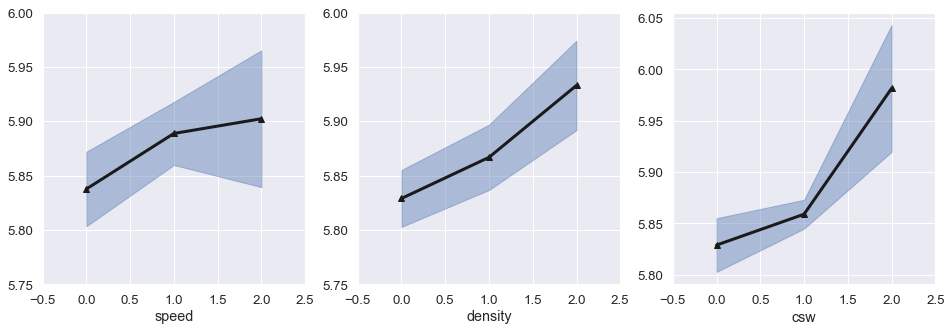

In [580]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

ax=axes[0]
# subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().plot(ax=axes[0])
subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.mean().plot(ax=axes[0],style='k^-', lw=3)
mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)
ax.set_xticks( [0,1,2], ['L','M','H'] )
ax.set_xlim(-.5,2.5)
ax.set_ylim(5.75,6.)


ax=axes[1]
# subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().plot(ax=axes[1],legend=False)
subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.mean().plot(ax=axes[1], style='k^-', lw=3)
mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)
ax.set_xlim(-.5,2.5)
ax.set_ylim(5.75,6.)

ax=axes[2]
# subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().plot(ax=axes[2],legend=False)
subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.mean().plot(ax=axes[2],style='k^-', lw=3)
mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)
# ax.set_ylim(5.7,6.2)
ax.set_xlim( mmm.index.min()-.5, mmm.index.max()+.5 )

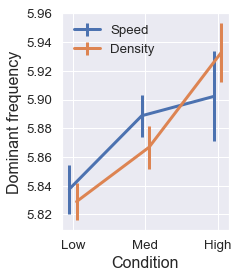

In [601]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.set_figheight(4)
fig.set_figwidth(3)

mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3 )

mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3 )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(axes)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);

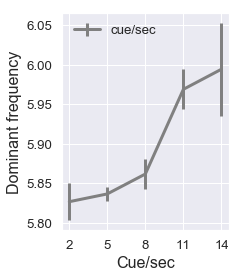

In [613]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
fig.set_figheight(4)
fig.set_figwidth(3)

mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color='grey' )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(axes)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
plt.xticks(np.arange(mmm.index.size), np.linspace(2,14,mmm.index.size).astype(int) );

In [655]:
print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('csw ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')





---------------------------------------------
Speed
FriedmanchisquareResult(statistic=3.5, pvalue=0.1737739434504451)
             sum_sq     df         F    PR(>F)
peakkss     0.93191    1.0  1.396664  0.237684
Residual  467.06809  700.0       NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)


              sum_sq     df         F    PR(>F)
peakkss     3.641878    1.0  5.489976  0.019405
Residual  464.358122  700.0       NaN       NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=12.200000000000003, pvalue=0.01592436080834918)
              sum_sq     df         F    PR(>F)
peakkss    10.508230    1.0  8.257245  0.004182
Residual  890.825104  700.0       NaN       NaN






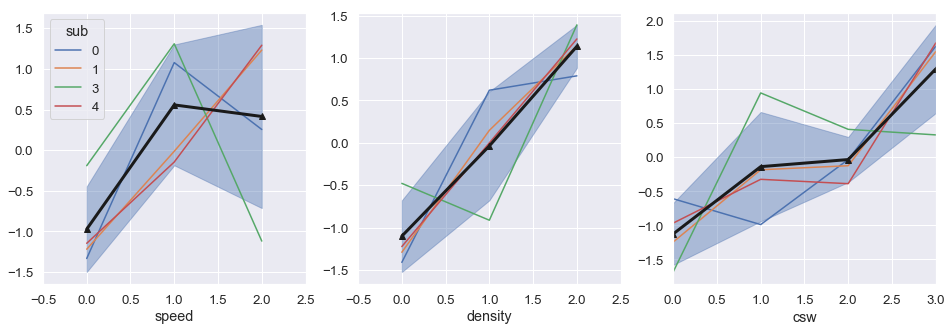

In [553]:
# subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot()
# plt.xlim(-.5,2.5)
# plt.show()
# subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot()
# plt.xlim(-.5,2.5)
# plt.show()
# subs_psd.groupby(['cuesec','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot()
# plt.show()
# subs_psd.groupby(['cuesec','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean().plot()



fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

ax=axes[0]
subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot(ax=axes[0])
subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean().plot(ax=axes[0],style='k^-', lw=3)
mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)
ax.set_xlim(-.5,2.5)


ax=axes[1]
subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot(ax=axes[1],legend=False)
subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean().plot(ax=axes[1], style='k^-', lw=3)
mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)
ax.set_xlim(-.5,2.5)

ax=axes[2]
subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).plot(ax=axes[2],legend=False)
subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean().plot(ax=axes[2],style='k^-', lw=3)
mmm = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.mean()
sss = subs_psd.groupby(['csw','sub']).mean()['peakkss'].unstack().apply(stats.zscore).T.sem()
ax.fill_between(mmm.index, mmm - 2 * sss, mmm + 2 * sss, color='b', alpha=0.4)


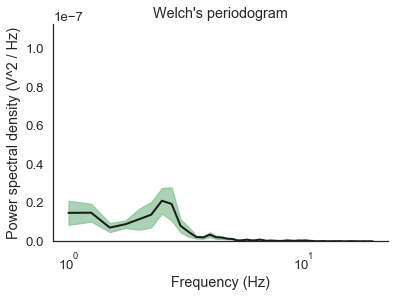

In [335]:
from scipy import stats as stats
mean_psd = np.mean(tmp_psd,axis=0)
sem_psd = stats.sem(tmp_psd,axis=0)



fmin=1
fmax=20
fmin_idx = np.argmin(np.abs(freqs-fmin))
fmax_idx = np.argmin(np.abs(freqs-fmax))


#     smooth_psd_sz         = 3
#     smooth_psd_sigma      = 2
#     psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)

#     peakkss = scipy.signal.find_peaks(psd[fmin_idx:fmax_idx])[0]
#     plt.plot(  freqs[peakkss], psd[peakkss], 'o', color=markercolor )

# # Plot the power spectrum
# sns.set(font_scale=1.2, style='white')
# #     plt.figure(figsize=(8, 4))
# plt.semilogx(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx], color='k', lw=2)
# plt.fill_between(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx]-sem_psd[fmin_idx:fmax_idx],
#                                            mean_psd[fmin_idx:fmax_idx]+sem_psd[fmin_idx:fmax_idx],alpha=0.5, color='g')


# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power spectral density (V^2 / Hz)')
# #     plt.ylim([0, psd.max() * 1.1])
# plt.ylim([0, 1*np.e**-16  ])
# plt.title("Welch's periodogram")
# # plt.xlim([ np.argmin(np.abs(freqs-fmin)) , np.argmin(np.abs(freqs-fmax)) ])
# sns.despine()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


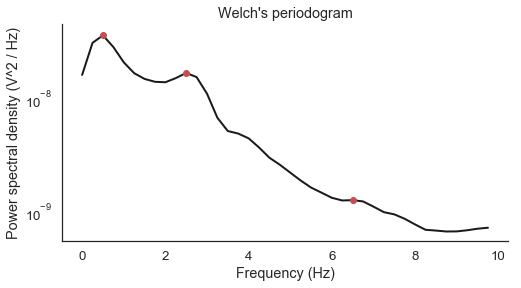

In [234]:
fmin = 0
fmax = 10
fmin_idx = np.argmin(np.abs(freqs-fmin))
fmax_idx = np.argmin(np.abs(freqs-fmax))

smooth_psd_sz         = 3
smooth_psd_sigma      = 2
s_psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)

peakkss = scipy.signal.find_peaks(s_psd[fmin_idx:fmax_idx])[0]



# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.semilogy(freqs[fmin_idx:fmax_idx], s_psd[fmin_idx:fmax_idx], color='k', lw=2)

plt.plot(  freqs[peakkss], s_psd[peakkss], 'ro' )
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
# plt.xlim([ np.argmin(np.abs(freqs-fmin)) , np.argmin(np.abs(freqs-fmax)) ])
sns.despine()